In [1]:
import numpy as np
import pulse2percept as p2p

/home/mbeyeler/anaconda3/lib/python3.5/site-packages/skvideo/__init__.py:356: UserWarning: avconv/avprobe not found in path: 
  warnings.warn("avconv/avprobe not found in path: " + str(path), UserWarning)
2017-07-11 16:34:00,247 [pulse2percept] [INFO] Welcome to pulse2percept


In [2]:
# Create your own implant
class MyImplant(p2p.implants.ElectrodeArray):
    
    def __init__(self, etype):
        """Custom electrode array
        
        Parameters
        ----------
        etype : str
            Electrode type, {'epiretinal', 'subretinal'}
        """
        self.etype = etype
        self.num_electrodes = 0
        self.electrodes = []

In [3]:
myimplant = MyImplant('epiretinal')
x, y = 0, 200  # distance to fovea (um)
h = 50  # height from retinal surface (um)
r = 150  # electrode radius (um)
myimplant.add_electrodes(r, x, y, h)

In [4]:
sim = p2p.Simulation(myimplant)

In [5]:
# Create your own TemporalModel
class MyTemporalModel(p2p.retina.BaseModel):
    def model_cascade(self, in_arr, pt_list, layers, dojit):
        """Custom ganglion cell model
        
        Parameters
        ----------
        in_arr: array-like
            A 2D array specifying the effective current values
            at a particular spatial location (pixel); one value
            per retinal layer and electrode.
            Dimensions: <#layers x #electrodes>
        pt_list : list
            List of pulse train ‘data‘ containers.
            Dimensions: <#electrodes x #time points>
        layers : list
            List of retinal layers to simulate.
            Choose from:
            - ’OFL’: optic fiber layer
            - ’GCL’: ganglion cell layer
            - ’INL’: inner nuclear layer
        dojit : bool
            If True, applies just-in-time (JIT) compilation to
            expensive computations for additional speed-up
            (requires Numba).
        """
        resp_inl = in_arr[0, :]
        resp_gcl = in_arr[1, :]
        resp = np.zeros_like(resp_gcl)
        if 'INL' in layers:
            resp += resp_inl
        if ('GCL' or 'OFL' in layers):
            resp += resp_gcl
        return p2p.utils.TimeSeries(self.tsample, resp)

In [6]:
mymodel = MyTemporalModel()
sim.set_ganglion_cell_layer(mymodel)

In [7]:
# Create your own stimulus
class MyBiphasicPulse(p2p.utils.TimeSeries):
    
    def __init__(self, pdur, tsample):
        """A charge-balanced pulse with a cathodic and anodic phase
        
        Parameters
        ----------
        pdur : float
            Duration of single (positive or negative) pulse phase (seconds).
        tsample : float
            Sampling time step (seconds).
        """
        on = p2p.stimuli.MonophasicPulse('anodic', pdur, tsample, 0, pdur)
        off = p2p.stimuli.MonophasicPulse('cathodic', pdur, tsample, 0, pdur)
        on.append(off)
        p2p.utils.TimeSeries.__init__(self, tsample, on)

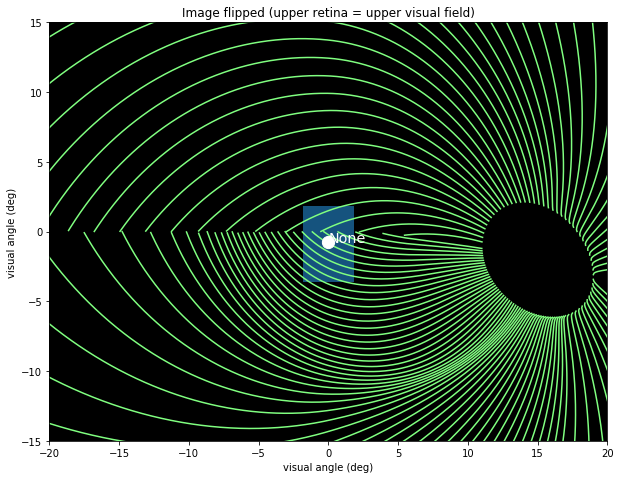

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
sim.plot_fundus();

In [9]:
percept = sim.pulse2percept(MyBiphasicPulse(0.001, 5e-6), tol=0.25, layers=['GCL'])

2017-07-11 16:34:01,209 [pulse2percept.api] [INFO] Starting pulse2percept...
2017-07-11 16:34:01,214 [pulse2percept.api] [INFO] tol=25.0%, 141/176 px selected
2017-07-11 16:34:01,319 [pulse2percept.api] [INFO] Done.


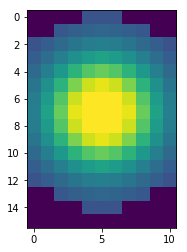

In [10]:
plt.imshow(p2p.get_brightest_frame(percept).data);